In [2]:
from __future__ import print_function, division
import sys,os
    
import numpy as np # type: ignore

from quspin.operators import hamiltonian, exp_op, quantum_operator # type: ignore 
from quspin.basis import spinful_fermion_basis_1d # type: ignore
from quspin.tools.measurements import obs_vs_time # type: ignore
import matplotlib.pyplot as plt # type: ignore

font = {
        'weight' : 'bold',
        'size'   : 16}
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', **font) 

figures_path = "../figs/"
model = "EHM_Quench_V_finite_time"

Model parameters


In [3]:
L = 7
J = 1.0

U_0 = 0.0
V_0 = 0.0

U_f = 0.0 
V_f = 3.0

tau = 2.5

# basis with symmetries
N = L//2
N_up = N + L%2
N_down = L - N_up

print("Nup = ", N_up,  "NDn = ", N_down)

basis = spinful_fermion_basis_1d(L,Nf=(N_up,N_down))
dim=basis.Ns

print("Size of 1D H-space: {Ns:d} \n".format(Ns=dim))
print(N, N_up, N_down)
# print(basis)

Nup =  4 NDn =  3
Size of 1D H-space: 1225 

3 4 3


Linear ramp in $V(t)$

In [4]:
'''
    Ramp driving for V(t) or U(t).
'''
def Drive_Control(t, x_0, x_f, tau_x):
    return x_0 + (x_f - x_0) * (t/tau_x)

'''
    Returns the structure for the time-independent part of 
    extended Hubbard Hamiltonian.

    - By default: open boundary conditions
'''
def EHM_Hamiltonian(L, U_0, V_0, J=1.0):
    
    hopping_right = [[-J, i, i+1] for i in range(L-1)]
    hopping_left  = [[+J, i, i+1] for i in range(L-1)]

    # Coulomb interaction
    on_site_interaction = [[U_0, i, i] for i in range(L)] 

    interact_v_right = [[V_0,i,i+1] for i in range(L-1)] # 
    interact_v_left = [[V_0,i+1,i] for i in range(L-1)] # 
    
    H_0 = [
        ['+-|', hopping_left],  # Hopping for spin-up
        ['-+|', hopping_right],
        ['|+-', hopping_left],  # Hopping for spin-down
        ['|-+', hopping_right],

        ['n|n', on_site_interaction],

        ['nn|',interact_v_right],   # up-up neighbor interaction
        ['|nn',interact_v_right],   # down-down neighbor interaction
        
        ['nn|',interact_v_left],   # up-up neighbor interaction
        ['|nn',interact_v_left],   # down-down neighbor interaction
        
        ['n|n',interact_v_right],   # up-down neighbor interaction
        ['n|n',interact_v_left],   # down-up neighbor interaction

    ]
    return H_0 
'''
    Returns the \\hat{V} time-dependent part of the Hamiltonian.
'''
def Quench_V(L, V_0, V_f, tau):

    driving_args_j = [V_0, V_f, tau]
    
    interact_v_right = [[1.0,i,i+1] for i in range(L-1)] # 
    interact_v_left = [[1.0,i+1,i] for i in range(L-1)] # 

    V_t = [

        ['nn|',interact_v_right, Drive_Control, driving_args_j],   # up-up neighbor interaction
        ['|nn',interact_v_right, Drive_Control, driving_args_j],   # down-down neighbor interaction,
        
        ['nn|',interact_v_left, Drive_Control, driving_args_j],   # up-up neighbor interaction
        ['|nn',interact_v_left, Drive_Control, driving_args_j],   # down-down neighbor interaction

        ['n|n',interact_v_right, Drive_Control, driving_args_j],   # up-down neighbor interaction
        ['n|n',interact_v_left , Drive_Control, driving_args_j],   # down-up neighbor interaction
    ]
    return V_t  


In [5]:
H_0 = EHM_Hamiltonian(L, U_0, V_0)
V_t = Quench_V(L, V_0, V_f, tau)

# Construct time-dependent Hamiltonian
H_t = hamiltonian(H_0, V_t, basis=basis, dtype=np.float64, check_pcon=True, check_symm=False)

# print(H_t.toarray())  # View matrix

E_GS, Psi_GS = H_t.eigsh(time = 0, k=1, which='SA')
E_GS_tau, Psi_GS_tau = H_t.eigsh(time=tau, k=1, which='SA')

print(f'ground-state energy: {E_GS}')
print(f'E_GS_tau: {E_GS_tau}')

Hermiticity check passed!
Particle conservation check passed!
ground-state energy: [-8.05467898]
E_GS_tau: [-1.35044482]


In [6]:
# the no-checks is just to avoid the printing of the message about Hermicity etc
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

N_t = 101
ts = np.linspace(0, tau, N_t)

Psi_ts = H_t.evolve(Psi_GS,ts[0],ts,rtol=1E-9,atol=1E-9, iterate=False)[:,0,:]

njUp_ts = np.zeros((N_t, L))
njDn_ts = np.zeros((N_t, L))
njDoublon_ts = np.zeros((N_t, L))

for j in range(L):
    NUpOp = hamiltonian([["n|",[[1.0, j]]]],[],basis=basis,**no_checks)
    NDnOp = hamiltonian([["|n",[[1.0, j]]]],[],basis=basis,**no_checks)

    for it in range(N_t):
        NupNdn_t = obs_vs_time(Psi_ts[:,it].reshape(dim,1),ts[it],dict(Nup=NUpOp, Ndn=NDnOp), return_state=False)
        ket = Psi_ts[:,it].reshape(dim,1)
        njUp_ts[it,j] = NupNdn_t['Nup'][0].real
        njDn_ts[it,j] = NupNdn_t['Ndn'][0].real

charge_density = njUp_ts + njDn_ts
magnetization = (njUp_ts - njDn_ts) / 2

charge_density_tau = charge_density[-1]
magnetization_tau = magnetization[-1]

Plot for local magnetization and charge density.

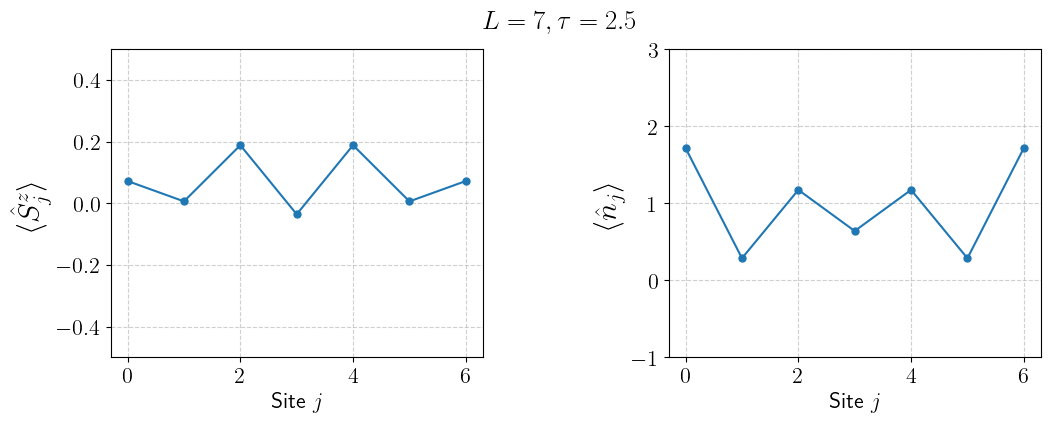

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# Connect points with lines
ax[0].plot(range(len(magnetization_tau)), magnetization_tau, '-o', markersize=5, linewidth=1.5, label=r'$m_j$')
ax[1].plot(range(len(charge_density_tau)), charge_density_tau, '-o', markersize=5, linewidth=1.5, label=r'$n_j$')

# Labels and Titles
ax[0].set_xlabel(r'Site $j$')
ax[1].set_xlabel(r'Site $j$')

ax[0].set_ylabel(r'$\langle \hat{S}^{z}_{j} \rangle$', fontsize=22)
ax[1].set_ylabel(r'$\langle \hat{n}_{j} \rangle $', fontsize=22)

ax[0].grid(True, linestyle='--', alpha=0.6)
ax[1].grid(True, linestyle='--', alpha=0.6)

ax[1].set_ylim(-1.0, 3.0)
ax[0].set_ylim(-0.5, 0.5)

# Adjust spacing
fig.subplots_adjust(wspace=0.5)
plt.suptitle(f"$L = {L}, \\tau = {tau}$")
fig.savefig(f"{figures_path}{model}/observables_evolved_state={L}_tau={tau}.png", dpi = 500, bbox_inches='tight')
plt.show()

Computing order parameter 

$$ 
    m_{\text{CDW}} = \frac{1}{L}\sum_{j} (-1)^{j} \left(\braket{\hat{n}_j} -1\right)
$$

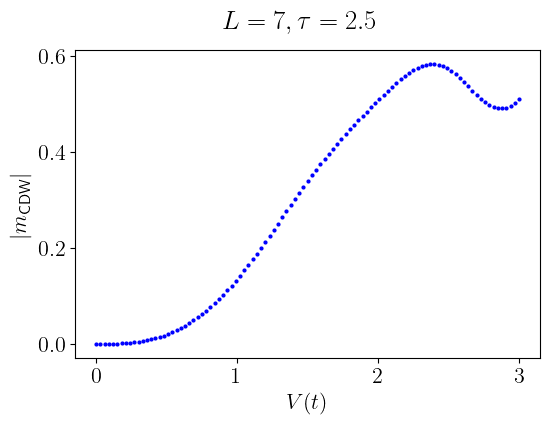

In [10]:
def m_CDW(L, nj): 
    m_cdw = 0
    for j in range(L):
        m_cdw += (-1)**(j) * (nj[j] - 1)
    return m_cdw / L 

fig, ax = plt.subplots(1,1, figsize=(6,4))

for t in range(N_t):
    m_cdw_t = m_CDW(L, charge_density[t])
    Vt = Drive_Control(ts[t], V_0, V_f, tau)
    ax.plot(Vt, np.abs(m_cdw_t), 'o', markersize=2.0, color="blue")

ax.set_xlabel(r'$V(t)$')
ax.set_ylabel(r'$|m_{\text{CDW}}|$')
plt.suptitle(f"$L = {L}, \\tau = {tau}$")
fig.savefig(f"{figures_path}{model}/order_parameter={L}_tau={tau}.png", dpi = 500, bbox_inches='tight')
plt.show()

Fidelity between evolved and equilibrium state at the CDW phase.

Nup =  3 NDn =  2
Size of 1D H-space: 100 

2 3 2
Running for tau = 0.01
Running for tau = 0.33
Running for tau = 2.0
Running for tau = 3.5
Running for tau = 5.0
Running for tau = 12.0
Running for tau = 20.0


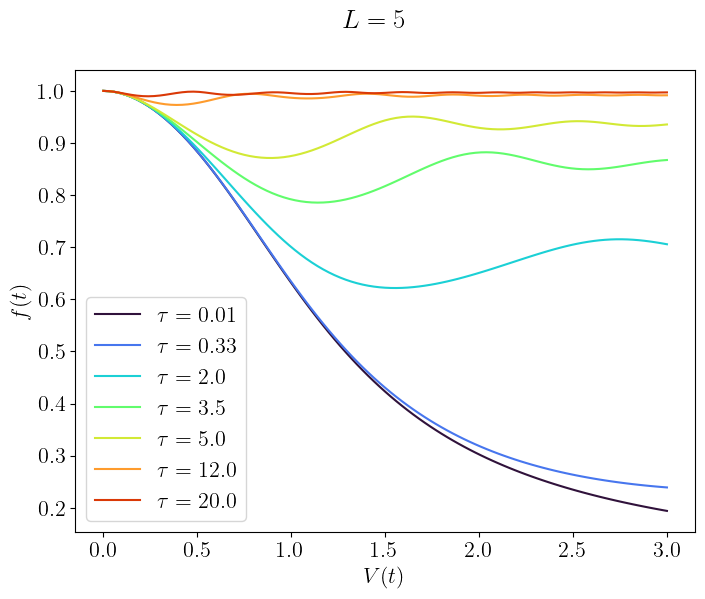

Nup =  4 NDn =  3
Size of 1D H-space: 1225 

3 4 3
Running for tau = 0.01
Running for tau = 0.33
Running for tau = 2.0
Running for tau = 3.5
Running for tau = 5.0
Running for tau = 12.0
Running for tau = 20.0


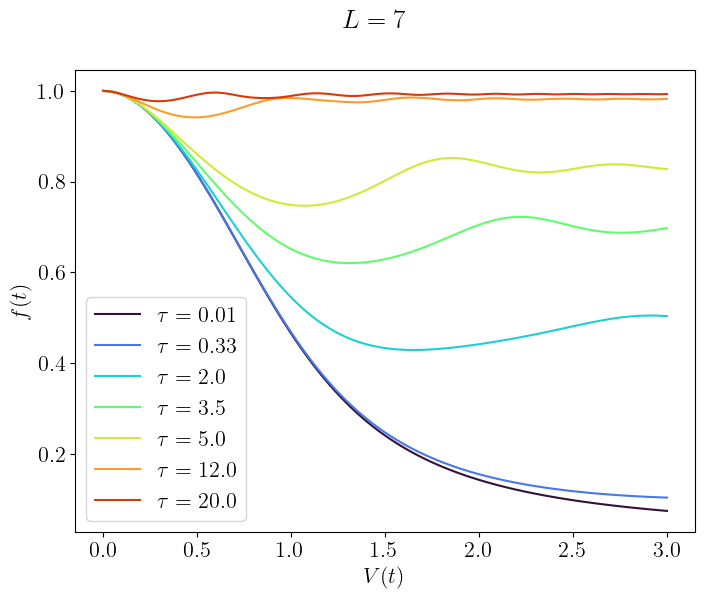

Nup =  5 NDn =  4
Size of 1D H-space: 15876 

4 5 4
Running for tau = 0.01
Running for tau = 0.33
Running for tau = 2.0
Running for tau = 3.5
Running for tau = 5.0
Running for tau = 12.0
Running for tau = 20.0


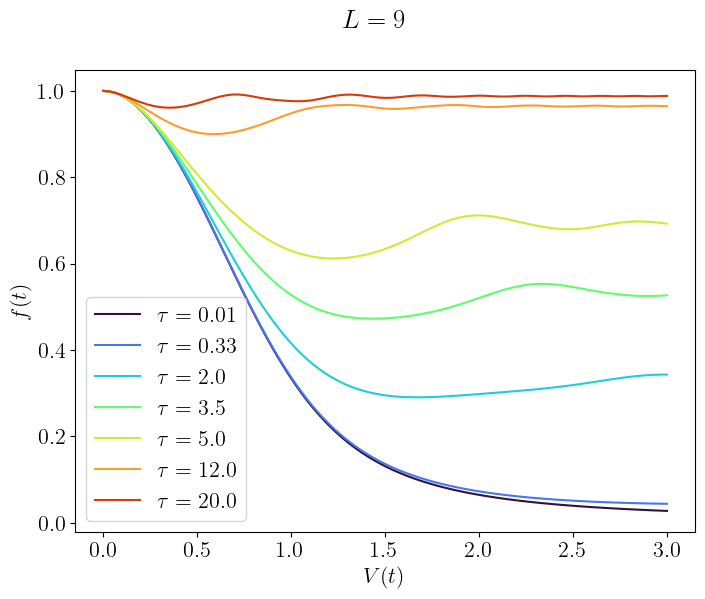

In [99]:
taus = [0.01, 0.33, 2.0, 3.5, 5.0, 12.0, 20.0]

Ls = [5, 7, 9]  # , 11]

for L in Ls:
    # basis with symmetries
    N = L//2
    N_up = N + L%2
    N_down = L - N_up

    print("Nup = ", N_up,  "NDn = ", N_down)

    basis = spinful_fermion_basis_1d(L,Nf=(N_up,N_down))
    dim=basis.Ns

    print("Size of 1D H-space: {Ns:d} \n".format(Ns=dim))
    print(N, N_up, N_down)
    # print(basis)

    H_0 = EHM_Hamiltonian(L, U_0, V_0)

    N_t = 101
    fidelity_t = np.zeros((len(taus), N_t))

    for i, tau in enumerate(taus):

        print(f"Running for tau = {tau}")
        
        V_t = Quench_V(L, V_0, V_f, tau)

        H_t = hamiltonian(H_0, V_t, basis=basis, dtype=np.float64,  **no_checks) # check_pcon=True, check_symm=False)

        E_GS, Psi_GS = H_t.eigsh(time = 0, k=1, which='SA')

        ts = np.linspace(0, tau, N_t)

        Psi_ts = H_t.evolve(Psi_GS,ts[0],ts,rtol=1E-9,atol=1E-9, iterate=False)[:,0,:]
        
        for t in range(N_t):
            _, Psi_GS_tau = H_t.eigsh(time=ts[t], k=1, which='SA')
            fidelity_t[i, t] = np.abs(np.vdot(Psi_ts[:, t], Psi_GS_tau))**2

    cmap = plt.cm.turbo  
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    for i, tau in enumerate(taus):
        ts = np.linspace(0, tau, N_t)
        Vt = np.array([Drive_Control(t, V_0, V_f, tau) for t in ts])
        
        color = cmap(i / len(taus)) 
        ax.plot(Vt, fidelity_t[i], color=color, label=f"$\\tau = {tau}$")

    fig.suptitle(f"$L = {L}$") # |\langle \Psi(t) |\Psi_{GS}^{\tau}\rangle|^2$")
    ax.set_xlabel(r'$V(t)$')
    ax.set_ylabel(r'$f(t)$')
    ax.legend()

    fig.savefig(f"{figures_path}{model}/fidelity_L={L}.png", dpi = 500, bbox_inches='tight')
    plt.show()